## Importieren der benötigten Bibliotheken
In diesem Abschnitt werden alle notwendigen Bibliotheken für das Projekt importiert:

- **pygame** – zur Darstellung der Flappy-Bird-Umgebung  
- **random** – für Zufallswerte, z. B. Pipe-Positionen  
- **pandas / numpy** – zur Datenverarbeitung und mathematischen Operationen  
- **torch, torch.nn, torch.optim** – für das neuronale Netz, seine Layer und den Optimierungsprozess  
- **deque** – für den Replay Buffer, um Erfahrungen effizient zu speichern  
- **matplotlib.pyplot** – zur Visualisierung der Trainingsergebnisse  
- **clear_output** – zum Aktualisieren der Ausgabe im Notebook während des Trainings

In [ ]:
import pygame
import random
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output


## Definition der Flappy-Bird-Umgebung
In dieser Klasse wird die RL-Umgebung für Flappy Bird definiert. 
Sie enthält alle wichtigen Komponenten des Spiels, wie Spielfeldgröße, Schwerkraft, Pipe-Logik und die Berechnung von Rewards. 
Die Methoden `reset()`, `get_state()`, `step()` und `render()` bilden die standardisierte RL-Schnittstelle:
- **reset()** – Setzt die Umgebung zu Beginn einer Episode zurück und liefert den Startzustand.  
- **get_state()** – Gibt den aktuellen Zustand als normalisiertes Array zurück.  
- **step(action)** – Führt eine Aktion aus, berechnet den Reward und gibt den nächsten Zustand sowie den Done-Status zurück.  
- **render()** – Visualisiert das Spiel während des Trainings oder der Evaluation.

In [29]:
class FlappyBirdEnv:
    def __init__(self):
        self.WIDTH = 288
        self.HEIGHT = 512
        self.BIRD_X = 50
        self.GRAVITY = 1.5
        self.JUMP_STRENGTH = -7
        self.PIPE_GAP = 150
        self.PIPE_WIDTH = 52
        self.PIPE_VELOCITY = 4

        self.flap_cooldown = 5
        self.flap_timer = 0

        pygame.init()
        self.screen = pygame.display.set_mode((self.WIDTH, self.HEIGHT))
        pygame.display.set_caption("Flappy Bird RL")

        self.font = pygame.font.SysFont(None, 32)

        self.clock = pygame.time.Clock()

        self.reset()

    def reset(self):
        self.bird_y = self.HEIGHT // 2
        self.bird_vel = 0
        self.pipe_x = self.WIDTH
        self.pipe_height = random.randint(50, self.HEIGHT - self.PIPE_GAP - 50)
        self.score = 0
        self.flap_timer = 0
        return self.get_state()

    def get_state(self):
        pipe_gap_center = self.pipe_height + self.PIPE_GAP / 2
        state = np.array([
            self.bird_y / self.HEIGHT,
            self.bird_vel / 10.0,
            (self.pipe_x - self.BIRD_X) / self.WIDTH,
            (pipe_gap_center - self.bird_y) / self.HEIGHT
        ], dtype=np.float32)
        return state

    def step(self, action):
        reward = 0.0

        if action == 1 and self.flap_timer <= 0:
            self.bird_vel = self.JUMP_STRENGTH
            self.flap_timer = self.flap_cooldown

        self.flap_timer -= 1
        self.bird_vel += self.GRAVITY
        self.bird_y += self.bird_vel

        self.pipe_x -= self.PIPE_VELOCITY

        if self.pipe_x < -self.PIPE_WIDTH:
            self.pipe_x = self.WIDTH
            self.pipe_height = random.randint(50, self.HEIGHT - self.PIPE_GAP - 50)
            self.score += 1
            reward += 10.0  # Mehr Reward für Pipe geschafft

        pipe_gap_center = self.pipe_height + self.PIPE_GAP / 2
        dist_to_center = abs(pipe_gap_center - self.bird_y)
        reward += max(0, 1.0 - (dist_to_center / (self.PIPE_GAP / 2)))  # Besser in der Mitte

        done = False
        if self.bird_y <= 0 or self.bird_y >= self.HEIGHT:
            done = True
            reward = -50.0

        if self.BIRD_X + 34 > self.pipe_x and self.BIRD_X < self.pipe_x + self.PIPE_WIDTH:
            if self.bird_y < self.pipe_height or self.bird_y > self.pipe_height + self.PIPE_GAP:
                done = True
                reward = -50.0

        return self.get_state(), reward, done

    def render(self, show=False, current_episode=0, max_score=0):
        if not show:
            return

        self.screen.fill((0, 0, 0))
        pygame.draw.rect(self.screen, (0, 255, 0), (self.pipe_x, 0, self.PIPE_WIDTH, self.pipe_height))
        pygame.draw.rect(self.screen, (0, 255, 0), (self.pipe_x, self.pipe_height + self.PIPE_GAP, self.PIPE_WIDTH, self.HEIGHT))
        pygame.draw.circle(self.screen, (255, 255, 0), (self.BIRD_X, int(self.bird_y)), 10)

        score_text = self.font.render(f"Score: {self.score}", True, (255, 255, 255))
        episode_text = self.font.render(f"Episode: {current_episode}", True, (255, 255, 255))
        maxscore_text = self.font.render(f"Max: {max_score}", True, (255, 255, 255))

        self.screen.blit(score_text, (10, 10))
        self.screen.blit(episode_text, (10, 40))
        self.screen.blit(maxscore_text, (10, 70))

        pygame.display.flip()
        self.clock.tick(30)


## Definition des Deep-Q-Networks (DQN)
Hier wird das neuronale Netz definiert, das die Q-Funktion approximiert.  
Das Modell erhält den Zustandsvektor als Eingabe und gibt für jede mögliche Aktion einen Q-Wert zurück.  
Die Architektur besteht aus:
- Eingabeschicht: Größe = Anzahl der Zustandsvariablen (`state_dim`)
- Zwei versteckte Schichten mit jeweils 128 Neuronen und ReLU-Aktivierungsfunktionen
- Ausgabeschicht: Größe = Anzahl der möglichen Aktionen (`action_dim`)

Die Methode `forward()` berechnet die Q-Werte für einen gegebenen Zustand.

In [30]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.net(x)


## Implementierung des Replay Buffers
Der Replay Buffer speichert Erfahrungen des Agenten in Form von Übergängen `(state, action, reward, next_state, done)`.  
Er dient dazu, die Korrelation zwischen aufeinanderfolgenden Schritten zu verringern und stabileres Training zu ermöglichen.  

**Funktionen:**
- `__init__(capacity)` – Legt die maximale Größe des Buffers fest.  
- `push()` – Fügt einen neuen Übergang hinzu.  
- `sample(batch_size)` – Gibt ein zufälliges Mini-Batch von Erfahrungen zurück.  
- `__len__()` – Gibt die aktuelle Anzahl gespeicherter Übergänge zurück.

In [31]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states, dtype=np.float32),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.uint8)
        )

    def __len__(self):
        return len(self.buffer)


## Training des DQN-Agenten
In diesem Abschnitt wird der eigentliche Trainingsprozess des RL-Agenten durchgeführt.  
Zunächst werden die Umgebung, das Policy-Netzwerk, das Target-Netzwerk, der Optimierer und der Replay Buffer initialisiert.  
Anschließend läuft eine Schleife über mehrere Episoden, in der der Agent nach dem **ε-greedy-Verfahren** Aktionen auswählt, Übergänge im Replay Buffer speichert und das Policy-Netzwerk mithilfe des DQN-Algorithmus trainiert.  

**Wichtige Schritte:**
- `epsilon` steuert den Grad der Exploration, der während des Trainings langsam reduziert wird.  
- `policy_net` wird trainiert, während `target_net` stabilere Q-Werte liefert und regelmäßig aktualisiert wird.  
- Die Q-Werte werden mittels Bellman-Gleichung aktualisiert (`expected_q`).  
- Rewards und Scores werden gespeichert, um den Trainingsfortschritt zu visualisieren.

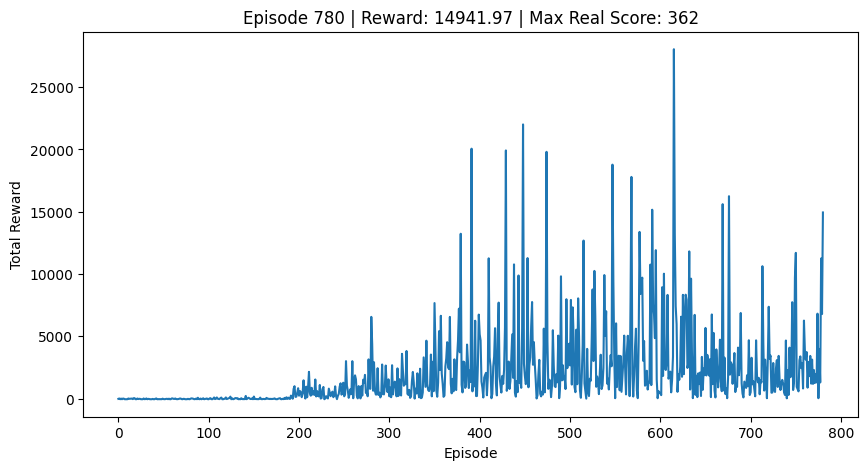

Episode: 781 | Reward: 5324.65 | Score: 69 | Max Score: 362
Episode: 782 | Reward: 1654.45 | Score: 23 | Max Score: 362
Episode: 783 | Reward: 717.01 | Score: 9 | Max Score: 362
Episode: 784 | Reward: 5888.90 | Score: 75 | Max Score: 362


KeyboardInterrupt: 

In [32]:
env = FlappyBirdEnv()

state_dim = 4
action_dim = 2

policy_net = DQN(state_dim, action_dim)
target_net = DQN(state_dim, action_dim)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
buffer = ReplayBuffer(100000)

epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.05
gamma = 0.99
batch_size = 64
target_update = 10

num_episodes = 2000
rewards = []
real_scores = []
epsilons = []

for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                exit()

        max_real_score = max(real_scores) if real_scores else 0
        env.render(show=(episode % 10 == 0), current_episode=episode, max_score=max_real_score)

        if random.random() < epsilon:
            action = random.randint(0, 1)
        else:
            with torch.no_grad():
                state_t = torch.FloatTensor(state).unsqueeze(0)
                q_values = policy_net(state_t)
                action = q_values.max(1)[1].item()

        next_state, reward, done = env.step(action)
        buffer.push(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        if len(buffer) >= batch_size:
            states, actions, rewards_b, next_states, dones = buffer.sample(batch_size)
            states = torch.FloatTensor(states)
            actions = torch.LongTensor(actions).unsqueeze(1)
            rewards_b = torch.FloatTensor(rewards_b).unsqueeze(1)
            next_states = torch.FloatTensor(next_states)
            dones = torch.FloatTensor(dones).unsqueeze(1)

            next_actions = policy_net(next_states).max(1)[1].unsqueeze(1)
            next_q = target_net(next_states).gather(1, next_actions)
            expected_q = rewards_b + gamma * next_q * (1 - dones)

            q_values = policy_net(states).gather(1, actions)

            loss = nn.MSELoss()(q_values, expected_q)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy_net.parameters(), max_norm=1.0)
            optimizer.step()

    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

    rewards.append(total_reward)
    real_scores.append(env.score)
    max_real_score = max(real_scores)

    print(f"Episode: {episode} | Reward: {total_reward:.2f} | Score: {env.score} | Max Score: {max_real_score}")

    if episode % 10 == 0:
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(rewards)
        plt.title(f"Episode {episode} | Reward: {total_reward:.2f} | Max Real Score: {max_real_score}")
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.show()

    if episode % 500 == 0:
        torch.save(policy_net.state_dict(), f"policy_net_ep{episode}.pth")

pygame.quit()


## Visualisierung der Trainingsergebnisse
Die folgende Funktion `plot_moving_average()` berechnet den gleitenden Durchschnitt der Rewards über ein definiertes Zeitfenster (`window`).  
Dies dient dazu, kurzfristige Schwankungen im Training zu glätten und den langfristigen Trend der Agentenleistung besser sichtbar zu machen.  

**Parameter:**
- `values` – Liste der Rewards pro Episode  
- `window` – Anzahl der Episoden, über die gemittelt wird  

Die Funktion verwendet `numpy.convolve()` zur Berechnung des gleitenden Mittels und `matplotlib` zur Darstellung als Liniendiagramm.

In [33]:
def plot_moving_average(values, window):
    if len(values) < window:
        window = len(values)
    moving_avg = np.convolve(values, np.ones(window)/window, mode='valid')
    plt.figure(figsize=(6,4))
    plt.plot(moving_avg)
    plt.title(f"Moving Average (window={window})")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.show()

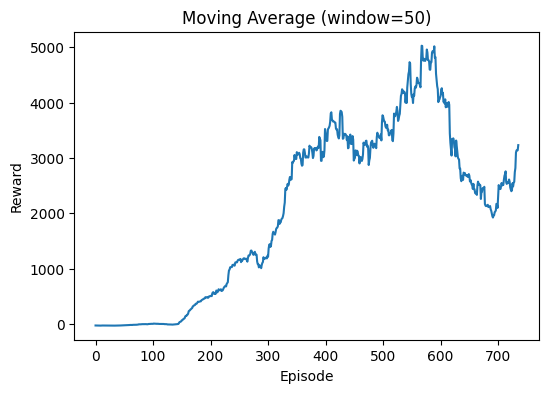

In [34]:
plot_moving_average(rewards, window=50)

## Histogramm der Rewards
Das folgende Diagramm zeigt die Verteilung der erzielten Rewards über alle Episoden.  
Ein Histogramm macht sichtbar, wie häufig bestimmte Reward-Bereiche erreicht wurden und ob der Agent im Laufe des Trainings öfter höhere Rewards erzielt.

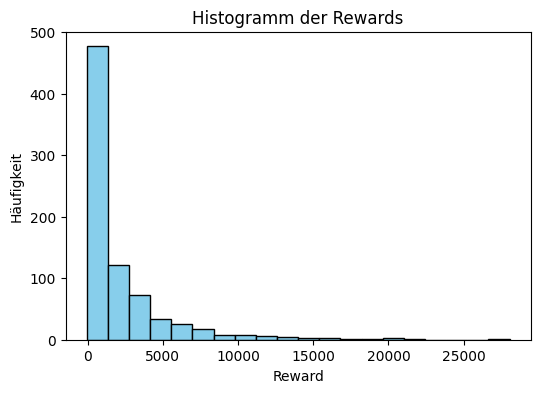

In [35]:
plt.figure(figsize=(6,4))
plt.hist(rewards, bins=20, color="skyblue", edgecolor="black")
plt.title("Histogramm der Rewards")
plt.xlabel("Reward")
plt.ylabel("Häufigkeit")
plt.show()

## Entwicklung von Durchschnitts- und Maximal-Reward
Hier werden zwei Kennwerte über die Episoden hinweg berechnet und geplottet:

- **avg_rewards** – Durchschnittlicher Reward bis zur jeweiligen Episode  
- **max_rewards** – Bisher höchster erzielter Reward  

Das Diagramm zeigt, wie sich sowohl die durchschnittliche Leistung als auch die beste bisher erzielte Leistung des Agenten im Verlauf des Trainings entwickeln.

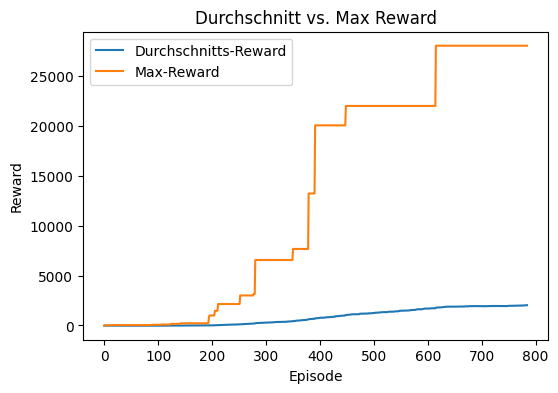

In [36]:
avg_rewards = [np.mean(rewards[:i+1]) for i in range(len(rewards))]
max_rewards = [np.max(rewards[:i+1]) for i in range(len(rewards))]

plt.figure(figsize=(6,4))
plt.plot(avg_rewards, label="Durchschnitts-Reward")
plt.plot(max_rewards, label="Max-Reward")
plt.title("Durchschnitt vs. Max Reward")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()